# NAVER 영화리뷰 감성분석

In [1]:
import pandas
import konlpy
import gensim
import tensorflow as tf
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.initializers import Constant
from tensorflow.keras import regularizers

import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings

from tensorflow.keras.layers import Bidirectional
%matplotlib inline
%config InlineBackend.figure_format='retina'
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
# loss, accuracy 그리기용 함수
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)
    
def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

## 1) 데이터 준비와 확인

In [3]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '..']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4) # 상위 10000개의  단어
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}
i = 0
for word, index in word_to_index.items():
    print(word, index)
    i += 1
    if i==10:
        break
del i

<PAD> 0
<BOS> 1
<UNK> 2
<UNUSED> 3
. 4
영화 5
다 6
고 7
하 8
을 9


## 2) data loader 구성

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]
print(get_decoded_sentence(X_train[0], index_to_word)[:45]) #1 번째 리뷰데이터의라벨
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [7]:
for i in range(31,60):
    print(get_decoded_sentence(X_train[i], index_to_word)[:45]) #1 번째 리뷰데이터의라벨
    print('라벨: ', y_train[i])  # 1번째 리뷰데이터의 라벨

쓰레기 진부 하 고 말 안 <UNK> 아 . . 시간 아까워
라벨:  0
는데 별점 왜 이리 낮 <UNK>
라벨:  1
% 라도 기대 했 던 내 죄인 입니다 죄인 입니다 . ...
라벨:  0
드라마 내인생의 최고 !
라벨:  1
대한 열정 ! 안나 <UNK> !
라벨:  1
<UNK> 연기 하 고자 했 던 건 대체 정신 장애 일까 틱 장애 일까
라벨:  0
. 원 작가 정신 나간 유령 라 . 재미있 겠 네요 !
라벨:  1
있 어 보이 는데 관객 <UNK> 명 네
라벨:  0
왜 이렇게 저 평가 받 는지 모르 겠 다
라벨:  1
하 면서 은은 매력 영화
라벨:  1
다 알 바 생 인가 내용 없 고 무서운 거 없 고 웃긴 거 하나 없 음 완전 별 
라벨:  0
게 두 어라 ! 서리 <UNK> 다 !
라벨:  1
맘 어요 . 그래서 또 보 고 싶 은데 또 보 방법 없 네 ? <UNK> ㅜㅡ
라벨:  1
라는 멋진 배우 발견 하 게 됐 어요 . 소소 일탈 잔잔 미소 머금 게 합니다 .
라벨:  1
속지 마시 길 시간 낭비 돈 낭비 임
라벨:  0
뛰어나 긴 한데 큰 공감 안 간다 . 이민기 캐릭터 정신 <UNK> 분노 조절 장
라벨:  0
왜 없 냐 ㅋ 뮤 비 보고 영화 수준 딱 알 만 하 더군 ㅉㅉ 북한 에서 이런 거
라벨:  0
우리 영화 사랑 합니다 . <UNK>
라벨:  0
리스 <UNK> <UNK> 엔 . 나 용 주인 되 고 싶 다 . <UNK> 랑 ,
라벨:  1
사람 영혼 을 <UNK> 줄 수 있 군요 거친 <UNK> 잠시 잊 고 동화 같 영
라벨:  1
<UNK> ! 작 고추 <UNK> 을 보여 주 마 ! 포 <UNK> 저그 콩 <U
라벨:  0
가슴 시리 게 본 드라마 또 있 을까 ? 감동 그 자체 !
라벨:  1
또 저 꼬마 애 무슨 원한 깊 길래 . ,. 했 더니 OO 그냥 혼자 나대 다 O
라벨:  0
어요
라벨:  1
좋 아요
라벨:  1

라벨:  0
충격 적 엇 다 . 기분 을 완전히 푹 꺼지 게 하 느낌 . <UNK> 라고 하나
라벨:

## 3) 모델 구성을 위한 데이터 분석 및 가공
모델에 넣어주기 위해서는 pad_sequence를 통해 데이터셋 상의 문장의 길이를 통일해야 한다. 또한 최대 문장의 길이를 정해주기 위하여 데이터셋의 분포를 봐야 한다.

In [8]:
def calc_tokens(x_train, x_test):
    
    total_data_text = list(x_train) + list(x_test)
    num_tokens = [len(tokens) for tokens in total_data_text]
    num_tokens = np.array(num_tokens)

    # 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
    print('문장길이 평균 : ', np.mean(num_tokens))
    print('문장길이 최대 : ', np.max(num_tokens))
    print('문장길이 표준편차 : ', np.std(num_tokens))

    # 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    print('pad_sequences maxlen : ', maxlen)
    print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))
    print('전체 문장의 {}%가 maxlen+5 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < (max_tokens+5)) / len(num_tokens)))
    print('전체 문장의 {}%가 maxlen+10 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < (max_tokens+10)) / len(num_tokens)))
    return maxlen
maxlen = calc_tokens(X_train, X_test)

문장길이 평균 :  15.813979799220842
문장길이 최대 :  116
문장길이 표준편차 :  12.756922913901299
pad_sequences maxlen :  41
전체 문장의 0.9354148429141134%가 maxlen 설정값 이내에 포함됩니다. 
전체 문장의 0.9502505899999488%가 maxlen+5 설정값 이내에 포함됩니다. 
전체 문장의 0.9641290269736202%가 maxlen+10 설정값 이내에 포함됩니다. 


In [9]:
maxlen = maxlen+10
maxlen

51

In [10]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 51)


## 4) 모델 구성 및 validation set 구성

In [11]:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.34, # test/train만큼
                                                  random_state=42)

print(partial_x_train.shape)
print(partial_y_train.shape)

(96480, 51)
(96480,)


In [12]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 128 # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(Bidirectional(tf.keras.layers.LSTM(10, return_sequences=False)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1280000   
_________________________________________________________________
dropout (Dropout)            (None, None, 128)         0         
_________________________________________________________________
bidirectional (Bidirectional (None, 20)                11120     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

## 5) 모델 train

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
189/189 [==============================] - 7s 15ms/step - loss: 0.5483 - accuracy: 0.7264 - val_loss: 0.4116 - val_accuracy: 0.8364
Epoch 2/5
189/189 [==============================] - 2s 12ms/step - loss: 0.4010 - accuracy: 0.8492 - val_loss: 0.3660 - val_accuracy: 0.8443
Epoch 3/5
189/189 [==============================] - 2s 12ms/step - loss: 0.3578 - accuracy: 0.8664 - val_loss: 0.3589 - val_accuracy: 0.8474
Epoch 4/5
189/189 [==============================] - 2s 12ms/step - loss: 0.3336 - accuracy: 0.8752 - val_loss: 0.3555 - val_accuracy: 0.8484
Epoch 5/5
189/189 [==============================] - 2s 12ms/step - loss: 0.3135 - accuracy: 0.8833 - val_loss: 0.3625 - val_accuracy: 0.8482


In [14]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 5s - loss: 0.3610 - accuracy: 0.8492


## 6) Loss, Accuracy 그래프 시각화

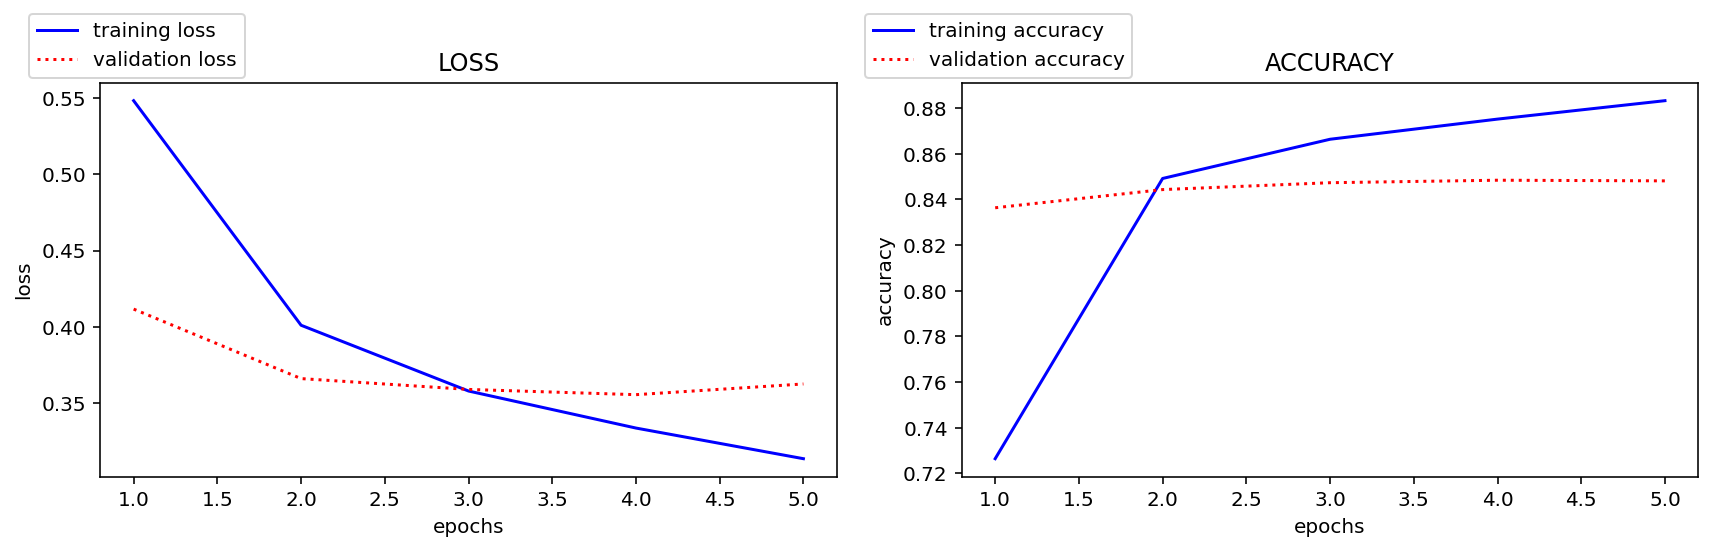

In [15]:
plot_history(history)

## 7) 학습된 Embedding layer 분석

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 128)


In [17]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [18]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['네이버']
vector

array([-0.00065667, -0.03763155, -0.00997203, -0.02450693, -0.03795913,
        0.05452443,  0.04481101,  0.06161349, -0.06473713,  0.01815066,
        0.03611046, -0.01524806, -0.08688249,  0.0322867 ,  0.01549593,
       -0.00224159, -0.07234676, -0.01486335, -0.01140129,  0.03109593,
       -0.04207231,  0.03240715, -0.00377932,  0.05293195, -0.0188877 ,
       -0.01916465, -0.0722724 ,  0.01833567, -0.02802159,  0.01880074,
       -0.01623823,  0.07927014,  0.00937403, -0.01326508, -0.00427607,
       -0.05319218, -0.05822421,  0.00542023,  0.02606162, -0.00024864,
       -0.05077965,  0.02844239, -0.04155466, -0.03683109,  0.03065824,
       -0.01445796,  0.03864914,  0.02979966, -0.04633947,  0.02186399,
        0.12050024, -0.03624518,  0.06491551, -0.0353309 ,  0.03151153,
        0.01932723,  0.02198987,  0.05331734, -0.02010295, -0.0091373 ,
       -0.08842113,  0.07818583,  0.05308216,  0.04297698,  0.01469964,
       -0.06222205,  0.06053808,  0.01432599, -0.00164158,  0.02

In [19]:
word_vectors.similar_by_word('사랑')

[('love', 0.7628036737442017),
 ('먹먹', 0.7551736235618591),
 ('왜냐하면', 0.7517075538635254),
 ('구할', 0.7483710050582886),
 ('울컥', 0.74766606092453),
 ('♥', 0.7444471716880798),
 ('은근', 0.743456244468689),
 ('풍성', 0.7412622570991516),
 ('헌신', 0.7411149740219116),
 ('훈', 0.7405925989151001)]

잘 학습된 것 같지는 않습니다

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

* 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
* 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요. [참고 링크1](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models), [참고 링크2](https://radimrehurek.com/gensim/models/keyedvectors.html)

### word vector 불러오기

In [12]:
# 예시 코드
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['사랑']
print(vector.shape)
word_vectors.wv.similar_by_word("사랑")

(100,)


[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [13]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

### 불러온 embedding으로 학습하기

#### model1 LSTM

In [22]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(20, kernel_regularizer=regularizers.L2(1e-3)))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 51, 100)           1000000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 51, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [23]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
189/189 [==============================] - 3s 10ms/step - loss: 0.7511 - accuracy: 0.5016 - val_loss: 0.7222 - val_accuracy: 0.5005
Epoch 2/30
189/189 [==============================] - 2s 8ms/step - loss: 0.7108 - accuracy: 0.5024 - val_loss: 0.7023 - val_accuracy: 0.5015
Epoch 3/30
189/189 [==============================] - 2s 8ms/step - loss: 0.6991 - accuracy: 0.5022 - val_loss: 0.6959 - val_accuracy: 0.5021
Epoch 4/30
189/189 [==============================] - 2s 8ms/step - loss: 0.6938 - accuracy: 0.5301 - val_loss: 0.6972 - val_accuracy: 0.5061
Epoch 5/30
189/189 [==============================] - 2s 8ms/step - loss: 0.6984 - accuracy: 0.5044 - val_loss: 0.6981 - val_accuracy: 0.5089
Epoch 6/30
189/189 [==============================] - 2s 8ms/step - loss: 0.6977 - accuracy: 0.5088 - val_loss: 0.6975 - val_accuracy: 0.5069
Epoch 7/30
189/189 [==============================] - 2s 8ms/step - loss: 0.6968 - accuracy: 0.5024 - val_loss: 0.6948 - val_accuracy: 0.5029
Epoch

In [24]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.3478 - accuracy: 0.8528


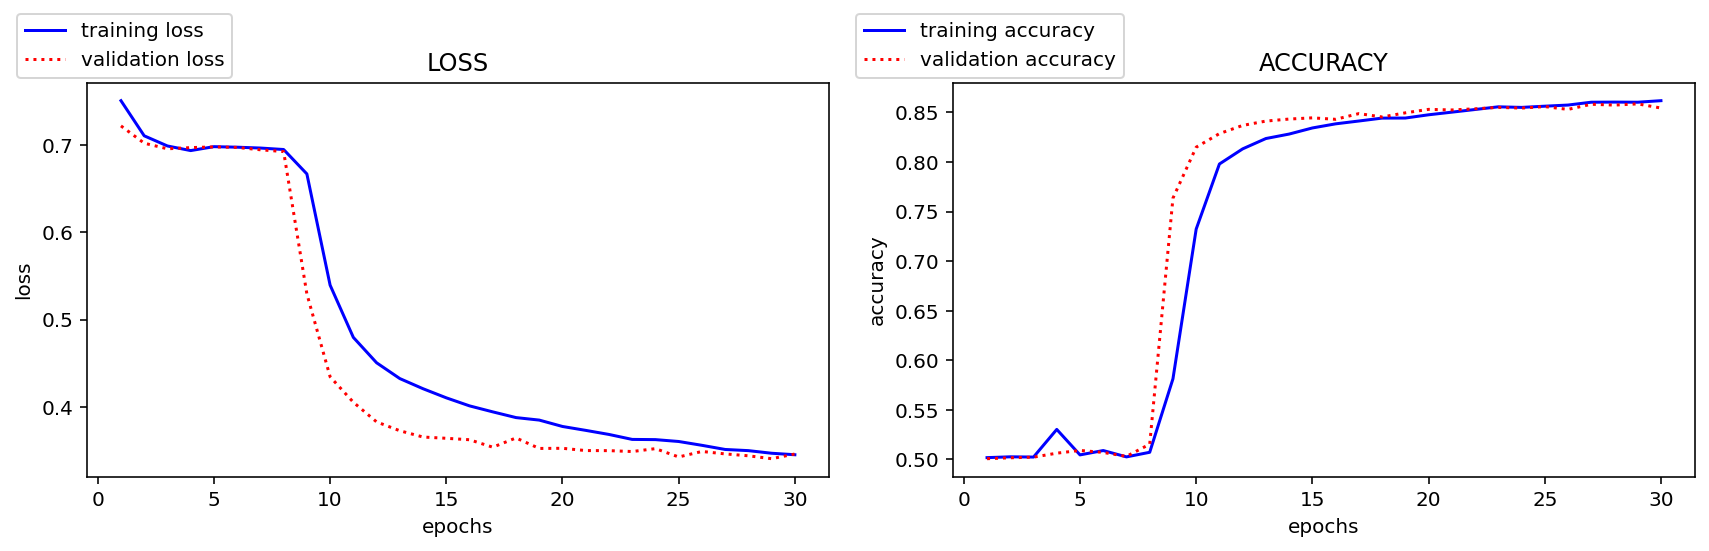

In [25]:
plot_history(history)

#### model2 CNN

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Conv1D(8, 7, activation='relu', kernel_regularizer=regularizers.L2(1e-3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling1D(4))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu', kernel_regularizer=regularizers.L2(1e-3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 51, 100)           1000000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 51, 100)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 45, 8)             5608      
_________________________________________________________________
batch_normalization (BatchNo (None, 45, 8)             32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 8)             0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 11, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 16)            

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
189/189 [==============================] - 4s 10ms/step - loss: 0.8560 - accuracy: 0.5032 - val_loss: 0.7173 - val_accuracy: 0.5058
Epoch 2/30
189/189 [==============================] - 2s 8ms/step - loss: 0.7272 - accuracy: 0.5065 - val_loss: 0.7144 - val_accuracy: 0.5114
Epoch 3/30
189/189 [==============================] - 2s 8ms/step - loss: 0.7157 - accuracy: 0.5139 - val_loss: 0.7025 - val_accuracy: 0.5522
Epoch 4/30
189/189 [==============================] - 2s 8ms/step - loss: 0.7030 - accuracy: 0.5402 - val_loss: 0.6719 - val_accuracy: 0.6274
Epoch 5/30
189/189 [==============================] - 2s 8ms/step - loss: 0.6832 - accuracy: 0.5727 - val_loss: 0.6304 - val_accuracy: 0.6985
Epoch 6/30
189/189 [==============================] - 2s 8ms/step - loss: 0.6618 - accuracy: 0.6008 - val_loss: 0.5995 - val_accuracy: 0.7154
Epoch 7/30
189/189 [==============================] - 2s 8ms/step - loss: 0.6341 - accuracy: 0.6352 - val_loss: 0.5566 - val_accuracy: 0.7442
Epoch

In [28]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 3s - loss: 0.3767 - accuracy: 0.8427


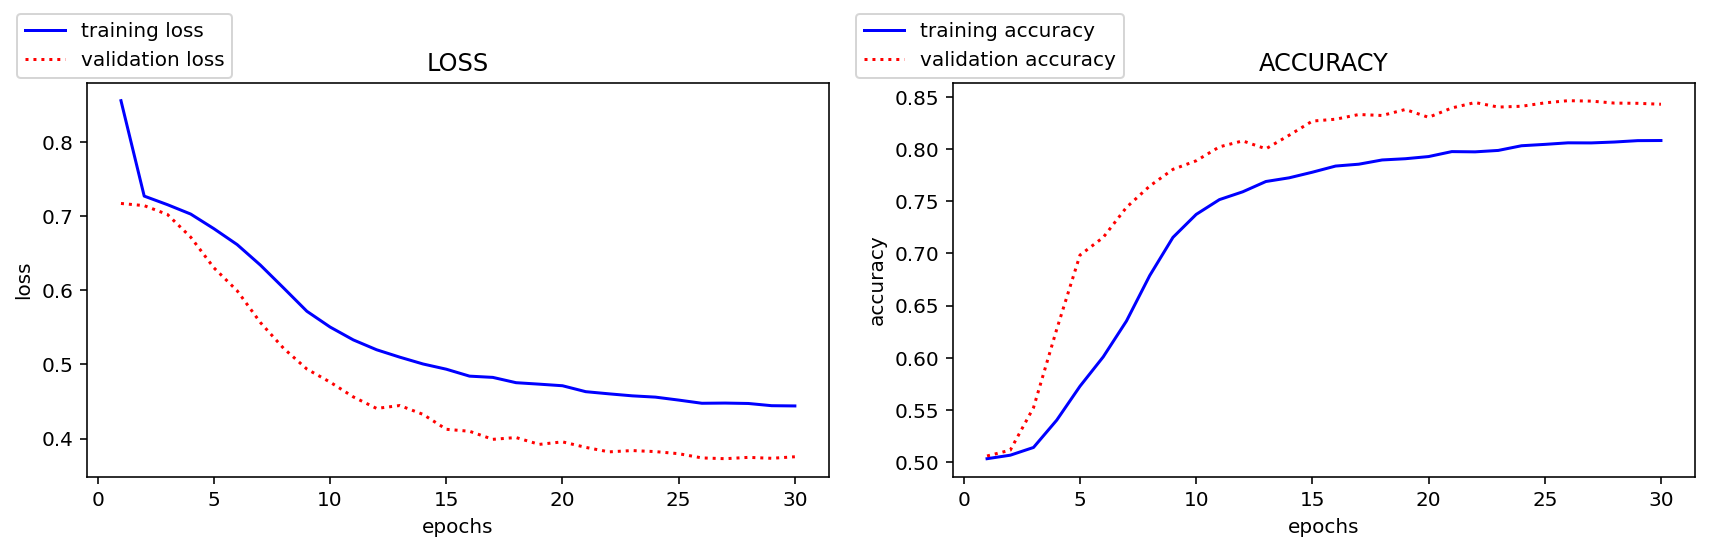

In [29]:
plot_history(history)

#### model 3 stacked LSTM

In [30]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.4))


model.add(Bidirectional(tf.keras.layers.LSTM(16,return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(Bidirectional(tf.keras.layers.LSTM(16)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 51, 100)           1000000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 51, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 51, 32)            14976     
_________________________________________________________________
dropout_11 (Dropout)         (None, 51, 32)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 32)                6272      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [31]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
189/189 [==============================] - 9s 24ms/step - loss: 0.6562 - accuracy: 0.5994 - val_loss: 0.5524 - val_accuracy: 0.7324
Epoch 2/30
189/189 [==============================] - 3s 17ms/step - loss: 0.5501 - accuracy: 0.7348 - val_loss: 0.4592 - val_accuracy: 0.7887
Epoch 3/30
189/189 [==============================] - 3s 18ms/step - loss: 0.4967 - accuracy: 0.7735 - val_loss: 0.4267 - val_accuracy: 0.8121
Epoch 4/30
189/189 [==============================] - 3s 18ms/step - loss: 0.4650 - accuracy: 0.7927 - val_loss: 0.3955 - val_accuracy: 0.8245
Epoch 5/30
189/189 [==============================] - 3s 18ms/step - loss: 0.4395 - accuracy: 0.8061 - val_loss: 0.3808 - val_accuracy: 0.8324
Epoch 6/30
189/189 [==============================] - 3s 18ms/step - loss: 0.4257 - accuracy: 0.8137 - val_loss: 0.3677 - val_accuracy: 0.8391
Epoch 7/30
189/189 [==============================] - 3s 18ms/step - loss: 0.4119 - accuracy: 0.8227 - val_loss: 0.3597 - val_accuracy: 0.8432

In [32]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 8s - loss: 0.3523 - accuracy: 0.8596


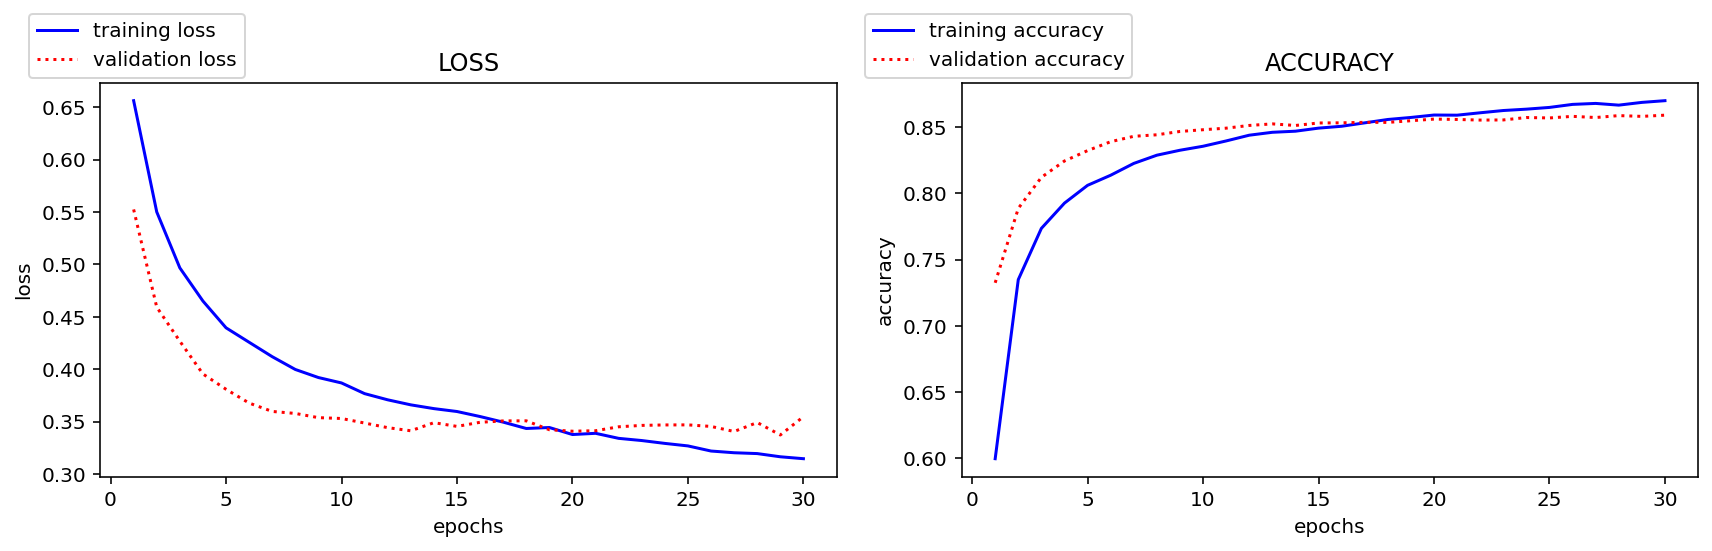

In [33]:
plot_history(history)

#### model 4 stacked GRU

In [34]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.4))


model.add(Bidirectional(tf.keras.layers.GRU(32,return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.7))

model.add(Bidirectional(tf.keras.layers.GRU(32,return_sequences=True)))
model.add(tf.keras.layers.Dropout(0.7))

model.add(Bidirectional(tf.keras.layers.GRU(32)))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(12, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 51, 100)           1000000   
_________________________________________________________________
dropout_14 (Dropout)         (None, 51, 100)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 51, 64)            25728     
_________________________________________________________________
dropout_15 (Dropout)         (None, 51, 64)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 51, 64)            18816     
_________________________________________________________________
dropout_16 (Dropout)         (None, 51, 64)            0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)               

In [35]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/30
189/189 [==============================] - 13s 34ms/step - loss: 0.6978 - accuracy: 0.5068 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 2/30
189/189 [==============================] - 5s 26ms/step - loss: 0.6874 - accuracy: 0.5285 - val_loss: 0.6036 - val_accuracy: 0.6874
Epoch 3/30
189/189 [==============================] - 5s 26ms/step - loss: 0.5864 - accuracy: 0.7008 - val_loss: 0.4649 - val_accuracy: 0.7862
Epoch 4/30
189/189 [==============================] - 5s 27ms/step - loss: 0.5064 - accuracy: 0.7700 - val_loss: 0.4320 - val_accuracy: 0.8133
Epoch 5/30
189/189 [==============================] - 5s 27ms/step - loss: 0.4650 - accuracy: 0.7924 - val_loss: 0.4311 - val_accuracy: 0.8254
Epoch 6/30
189/189 [==============================] - 5s 27ms/step - loss: 0.4394 - accuracy: 0.8082 - val_loss: 0.3832 - val_accuracy: 0.8357
Epoch 7/30
189/189 [==============================] - 5s 27ms/step - loss: 0.4213 - accuracy: 0.8172 - val_loss: 0.3859 - val_accuracy: 0.837

In [36]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 11s - loss: 0.3494 - accuracy: 0.8592


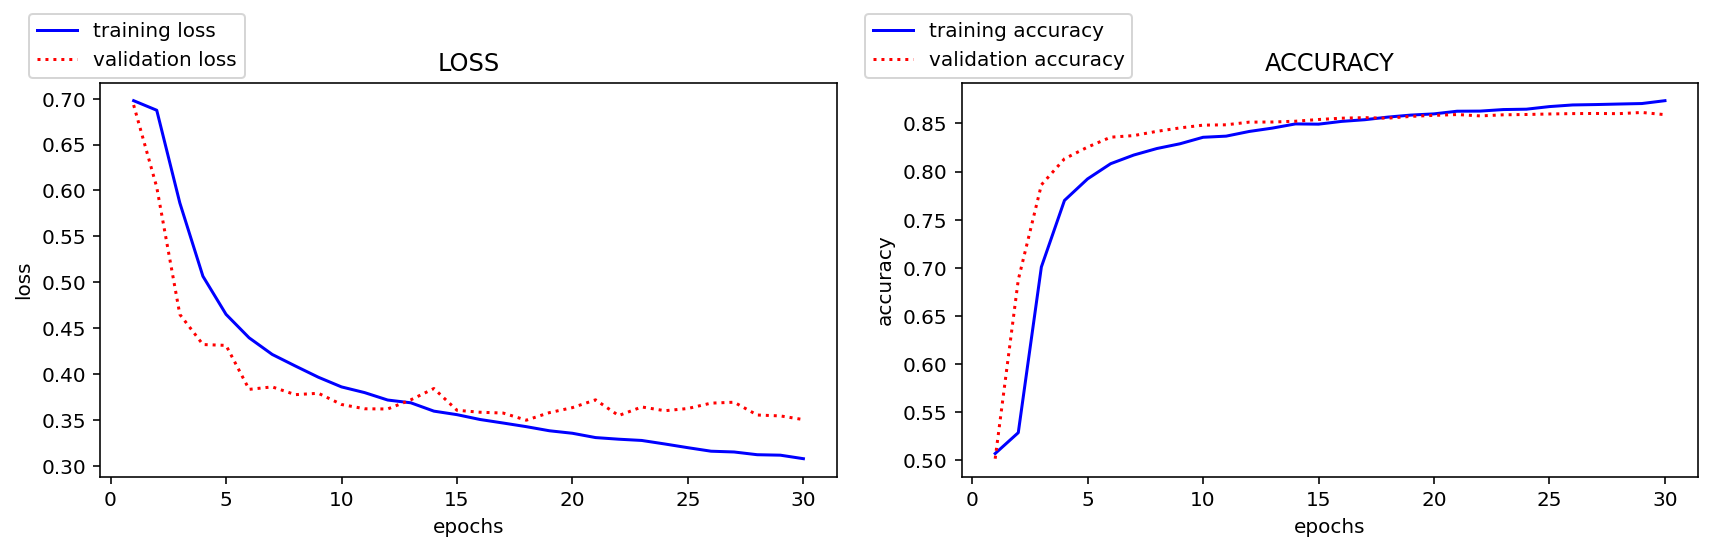

In [37]:
plot_history(history)

#### 성능 높히기 실험

In [35]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dropout(0.4))


model.add(Bidirectional(tf.keras.layers.GRU(16,return_sequences=True, recurrent_regularizer='l2')))
model.add(tf.keras.layers.Dropout(0.6))

model.add(Bidirectional(tf.keras.layers.GRU(16, recurrent_regularizer='l2')))
model.add(tf.keras.layers.Dropout(0.6))


model.add(tf.keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(tf.keras.layers.Dropout(0.6))


model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 51, 100)           1000000   
_________________________________________________________________
dropout_29 (Dropout)         (None, 51, 100)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 51, 64)            6464      
_________________________________________________________________
dropout_30 (Dropout)         (None, 51, 64)            0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 51, 32)            7872      
_________________________________________________________________
dropout_31 (Dropout)         (None, 51, 32)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 32)               

In [36]:
lr = 0.001
def scheduler(epoch, lr):
      if epoch > 50:
          return lr * tf.math.exp(-0.1)
      else:
          return lr

sc = tf.keras.callbacks.LearningRateScheduler(scheduler)
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=100 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    callbacks=[sc, es],
                    verbose=1)

Epoch 1/100
189/189 [==============================] - 9s 24ms/step - loss: 1.0005 - accuracy: 0.4982 - val_loss: 0.7793 - val_accuracy: 0.5005
Epoch 2/100
189/189 [==============================] - 3s 18ms/step - loss: 0.7350 - accuracy: 0.5001 - val_loss: 0.7055 - val_accuracy: 0.5006
Epoch 3/100
189/189 [==============================] - 3s 18ms/step - loss: 0.7001 - accuracy: 0.5012 - val_loss: 0.6950 - val_accuracy: 0.5006
Epoch 4/100
189/189 [==============================] - 4s 19ms/step - loss: 0.6945 - accuracy: 0.5016 - val_loss: 0.6934 - val_accuracy: 0.5006
Epoch 5/100
189/189 [==============================] - 3s 18ms/step - loss: 0.6935 - accuracy: 0.5034 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 6/100
189/189 [==============================] - 3s 18ms/step - loss: 0.6930 - accuracy: 0.5056 - val_loss: 0.6929 - val_accuracy: 0.5006
Epoch 7/100
189/189 [==============================] - 4s 19ms/step - loss: 0.6923 - accuracy: 0.5130 - val_loss: 0.6869 - val_accuracy:

In [37]:
results = model.evaluate(X_test,  y_test, verbose=2)

1537/1537 - 8s - loss: 0.3540 - accuracy: 0.8514


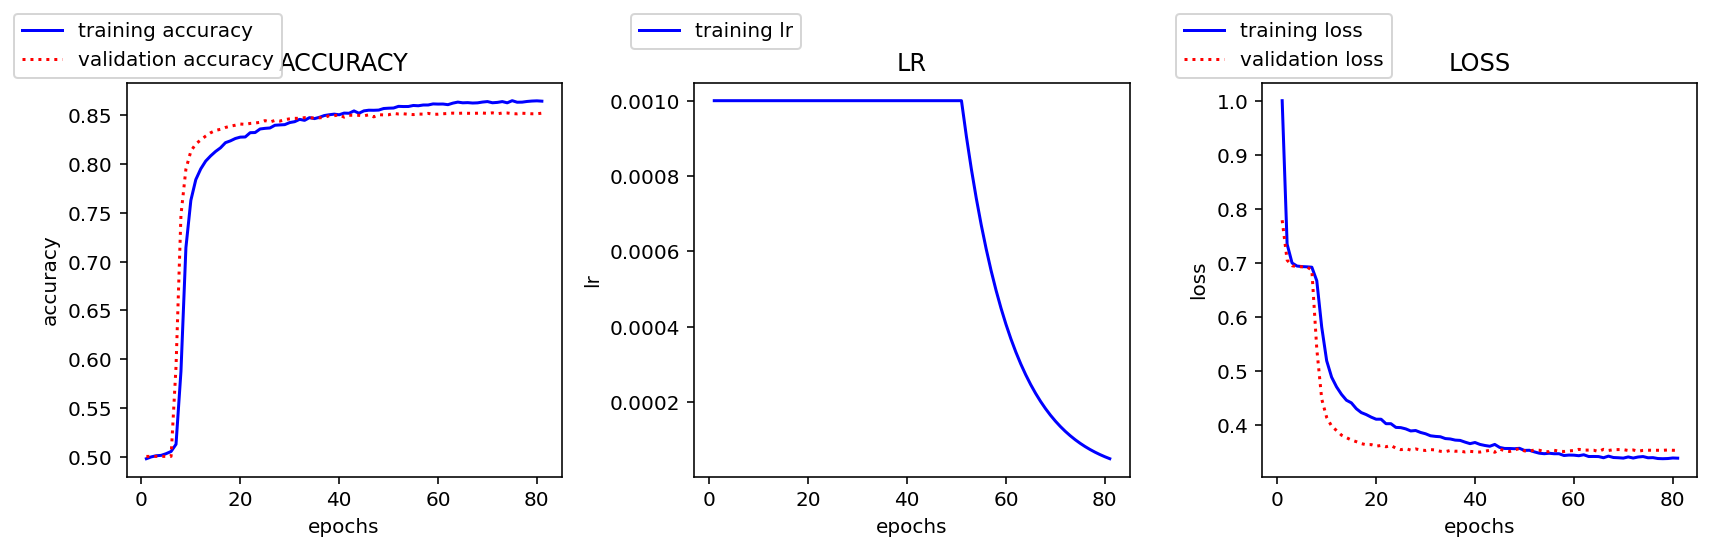

In [38]:
plot_history(history)

성능을 더 올리는데에는 실패했다. LSTM을 두개 쌓은 모델 3 이 test accuracy 0.8596으로 가장 성능이 좋았다.

# 예측 결과 보기
진행중

In [42]:
# def classifier():
#     while True:
#         sentence = [input('문장을 입력하세요, 종료시 q를 입력: ')]
#         if sentence == 'q':
#             break
#         else:
#             print(f'입력된 문장: {sentence[0]}')
#             s = get_encoded_sentence(sentence[0], word_to_index)
#             tf.keras.preprocessing.sequence.pad_sequences(s,
#                                                        value=word_to_index["<PAD>"],
#                                                        padding='post', # 혹은 'pre'
#                                                        maxlen=maxlen)
#             print(f'변환된 문장: {get_decoded_sentence(s, index_to_word)}')
# classifier()

In [43]:
# s = get_encoded_sentence('이 영화 맛있다', word_to_index)
# print(f'입력된 문장: {}')
# tf.keras.preprocessing.sequence.pad_sequences(s,
#                                            value=word_to_index["<PAD>"],
#                                            padding='post', # 혹은 'pre'
#                                            maxlen=maxlen)
# print(f'변환된 문장: {get_decoded_sentence(s, index_to_word)}')